In [2]:
# Import all necessary libraries

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.python.ops.numpy_ops import np_config

import numpy as np
import os
from PIL import Image
import cv2
from PIL import ImageFilter
import textwrap, os

In [3]:
# Declaration of the hyperparameters

# data
num_epochs = 500 
image_size = 32
# resolution of Kernel Inception Distance measurement, see related section
kid_image_size = 75
padding = 0.25

# adaptive discriminator augmentation
max_translation = 0.125
max_rotation = 0.125
max_zoom = 0.25
target_accuracy = 0.85
integration_steps = 1000

# architecture
noise_size = 128
depth = 4
width = 128
leaky_relu_slope = 0.2
dropout_rate = 0.4

# optimization
batch_size = 128
learning_rate = 2e-3
beta_1 = 0.5
ema = 0.99

In [4]:
class KID(keras.metrics.Metric):
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()
   

In [5]:
# "hard sigmoid", useful for binary accuracy calculation from logits
def step(values):
    # negative values -> 0.0, positive values -> 1.0
    return 0.5 * (1.0 + tf.sign(values))


# augments images with a probability that is dynamically updated during training
class AdaptiveAugmenter(keras.Model):
    def __init__(self):
        super().__init__()

        # stores the current probability of an image being augmented
        self.probability = tf.Variable(0.0)

        # the corresponding augmentation names from the paper are shown above each layer
        # the authors show, that the blitting and geometric augmentations
        # are the most helpful in the low-data regime
        self.augmenter = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                # blitting/x-flip:
                layers.RandomFlip("horizontal"),
                # blitting/integer translation:
                layers.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                layers.RandomRotation(factor=max_rotation),
                # geometric/isotropic and anisotropic scaling:
                layers.RandomZoom(
                    height_factor=(-max_zoom, 0.0), width_factor=(-max_zoom, 0.0)
                ),
            ],
            name="adaptive_augmenter",
        )

    def call(self, images, training):
        if training:
            augmented_images = self.augmenter(images, training)

            # during training either the original or the augmented images are selected
            # based on self.probability
            augmentation_values = tf.random.uniform(
                shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
            )
            augmentation_bools = tf.math.less(augmentation_values, self.probability)

            images = tf.where(augmentation_bools, augmented_images, images)
        return images

    def update(self, real_logits):
        current_accuracy = tf.reduce_mean(step(real_logits))

        # the augmentation probability is updated based on the dicriminator's
        # accuracy on real images
        accuracy_error = current_accuracy - target_accuracy
        self.probability.assign(
            tf.clip_by_value(
                self.probability + accuracy_error / integration_steps, 0.0, 1.0
            )
        )        

# DCGAN generator
def get_generator():

    # receive noise_input
    noise_input = keras.Input(shape=(noise_size,))
    # dense neural network
    x = layers.Dense(4 * 4 * width, use_bias=False)(noise_input)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)
    # reshape to pass it through the convolutional networks for "upsampling" and generating the desired images
    x = layers.Reshape(target_shape=(4, 4, width))(x)
    # first same convolution to increase number of channels while keeping the size
    x = layers.Conv2DTranspose(
        width*2, kernel_size=4, strides=1, padding="same", use_bias=False,
    )(x)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)    
    # convolutions to increase the size to generate the novel images
    x = layers.Conv2DTranspose(
        width*2, kernel_size=4, strides=2, padding="same", use_bias=False,
    )(x)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)     
    x = layers.Conv2DTranspose(
        width*2, kernel_size=4, strides=2, padding="same", use_bias=False,
    )(x)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x) 
    # second same convolution to decrease number of channels while keeping the size
    x = layers.Conv2DTranspose(
        width, kernel_size=4, strides=1, padding="same", use_bias=False,
    )(x)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x) 
    # last convolution with sigmoid activation to get the image 
    image_output = layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", activation="sigmoid",
    )(x)

    return keras.Model(noise_input, image_output, name="generator")


# DCGAN discriminator
def get_discriminator():
    image_input = keras.Input(shape=(image_size, image_size, 3))
    x = image_input
    for _ in range(depth):
        x = layers.Conv2D(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.LeakyReLU(alpha=leaky_relu_slope)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_score = layers.Dense(1,activation="sigmoid")(x)

    return keras.Model(image_input, output_score, name="discriminator")


class GAN_ADA(keras.Model):
    def __init__(self):
        super().__init__()

        self.augmenter = AdaptiveAugmenter()
        self.generator = get_generator()
        self.ema_generator = keras.models.clone_model(self.generator)
        self.discriminator = get_discriminator()

        self.generator.summary()
        self.discriminator.summary()

    def compile(self, generator_optimizer, discriminator_optimizer, **kwargs):
        super().compile(**kwargs)

        # separate optimizers for the two networks
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.generator_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.discriminator_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.real_accuracy = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_accuracy = keras.metrics.BinaryAccuracy(name="gen_acc")
        self.augmentation_probability_tracker = keras.metrics.Mean(name="aug_p")
        self.kid = KID()

    @property
    def metrics(self):
        return [
            self.generator_loss_tracker,
            self.discriminator_loss_tracker,
            self.real_accuracy,
            self.generated_accuracy,
            self.augmentation_probability_tracker,
            self.kid,
        ]

    def generate(self, batch_size, training):
        latent_samples = tf.random.normal(shape=(batch_size, noise_size))
        # use ema_generator during inference
        if training:
            generated_images = self.generator(latent_samples, training)
        else:
            generated_images = self.ema_generator(latent_samples, training)
        return generated_images

    def adversarial_loss(self, real_logits, generated_logits):
        # this is usually called the non-saturating GAN loss

        real_labels = tf.ones(shape=(batch_size, 1))
        generated_labels = tf.zeros(shape=(batch_size, 1))

        # the generator tries to produce images that the discriminator considers as real
        generator_loss = keras.losses.binary_crossentropy(
            real_labels, generated_logits, from_logits=True
        )
        # the discriminator tries to determine if images are real or generated
        discriminator_loss = keras.losses.binary_crossentropy(
            tf.concat([real_labels, generated_labels], axis=0),
            tf.concat([real_logits, generated_logits], axis=0),
            from_logits=True,
        )

        return tf.reduce_mean(generator_loss), tf.reduce_mean(discriminator_loss)

    def train_step(self, real_images):
        real_images = self.augmenter(real_images, training=True)

        # use persistent gradient tape because gradients will be calculated twice
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generate(batch_size, training=True)
            # gradient is calculated through the image augmentation
            generated_images = self.augmenter(generated_images, training=True)

            # separate forward passes for the real and generated images, meaning
            # that batch normalization is applied separately
            real_logits = self.discriminator(real_images, training=True)
            generated_logits = self.discriminator(generated_images, training=True)

            generator_loss, discriminator_loss = self.adversarial_loss(
                real_logits, generated_logits
            )

        # calculate gradients and update weights
        generator_gradients = tape.gradient(
            generator_loss, self.generator.trainable_weights
        )
        discriminator_gradients = tape.gradient(
            discriminator_loss, self.discriminator.trainable_weights
        )
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_weights)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_weights)
        )

        # update the augmentation probability based on the discriminator's performance
        self.augmenter.update(real_logits)

        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)
        self.real_accuracy.update_state(1.0, step(real_logits))
        self.generated_accuracy.update_state(0.0, step(generated_logits))
        self.augmentation_probability_tracker.update_state(self.augmenter.probability)

        # track the exponential moving average of the generator's weights to decrease
        # variance in the generation quality
        for weight, ema_weight in zip(
            self.generator.weights, self.ema_generator.weights
        ):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, real_images):
        generated_images = self.generate(batch_size, training=False)

        self.kid.update_state(real_images, generated_images)

        # only KID is measured during the evaluation phase for computational efficiency
        return {self.kid.name: self.kid.result()}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6, interval=5):
        # plot random generated images for visual evaluation of generation quality
        if epoch is None or (epoch + 1) % interval == 0:
            num_images = num_rows * num_cols
            generated_images = self.generate(num_images, training=False)

            plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
            for row in range(num_rows):
                for col in range(num_cols):
                    index = row * num_cols + col
                    plt.subplot(num_rows, num_cols, index + 1)
                    plt.imshow(generated_images[index])
                    plt.axis("off")
            plt.tight_layout()
            plt.show()
            plt.close()
            
            
            
# create and compile the model
model = GAN_ADA()
model.compile(
    generator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
    discriminator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
)

# save the best model based on the validation KID metric
checkpoint_path = "gan_model_ll"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 2048)              262144    
                                                                 
 batch_normalization (BatchN  (None, 2048)             6144      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        524288    
 nspose)                                                 

                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 794,625
Trainable params: 793,601
Non-trainable params: 1,024
_________________________________________________________________


In [6]:
# Load weights learned during training

model.load_weights("DCGAN_Cifar_Plane_same")

In [7]:
# Load ESRGAN model to increase the size of the generated images and improve their resolution 

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
# Declaring Constants
ESRGAN_path = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model_super = hub.load(ESRGAN_path)


Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [8]:
# Post Processing Functions to increase the size and resolution of the generated images

def postprocess(image_tensor):

    size = image_tensor.shape[1]
    new_size = size * 2
    # Upsample the image using TensorFlow
    resized_image = tf.image.resize(image_tensor, [new_size, new_size], method=tf.image.ResizeMethod.BICUBIC)

    # Apply denoising using OpenCV
    denoised_image = cv2.medianBlur(resized_image.numpy(), 3)

    #Applying sharpening filter
    pil_img = tf.keras.preprocessing.image.array_to_img(denoised_image)
    sharp = pil_img.filter(ImageFilter.SHARPEN)

    return sharp

def resize_res(image_tensor):

    # First denoise the image and prepare it for the ESRGAN model 
    denoised_image = cv2.medianBlur(image_tensor.numpy(), 3)
    image = tf.expand_dims(denoised_image, 0)
    image = image * 255

    # Improve the image with the ESRGAN model
    fake_image = model_super(image,training=False)

    # Prepare image for plotting and later use
    fake_image = tf.squeeze(fake_image)
    fake_image = fake_image / 255

    return fake_image


In [9]:
def display_images(images):

    # Declare necessary variables for plotting configuration
    columns=5
    width=25
    height=10
    max_images=15 

    # Check if there are images for plotting
    if not images:
        print("No images to display.")
        return 

    # Plotting configuration    
    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))

    # Plot the images in subplots
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

tf.Tensor(
[0.9861286  0.9764933  0.97305596 0.972645   0.97244656 0.96979815
 0.96944374 0.9653927  0.95772344 0.9559752  0.9523633  0.94907755
 0.9480108  0.94722813 0.9468049  0.94443035 0.9430833  0.9426806
 0.9425947  0.94241476], shape=(20,), dtype=float32)
tf.Tensor(
[1266 2990  128 6615 3398  463 9528 7306 3371 6718 4723  899 1425 6743
 8478 9840 8052 4063 2527 8447], shape=(20,), dtype=int32)


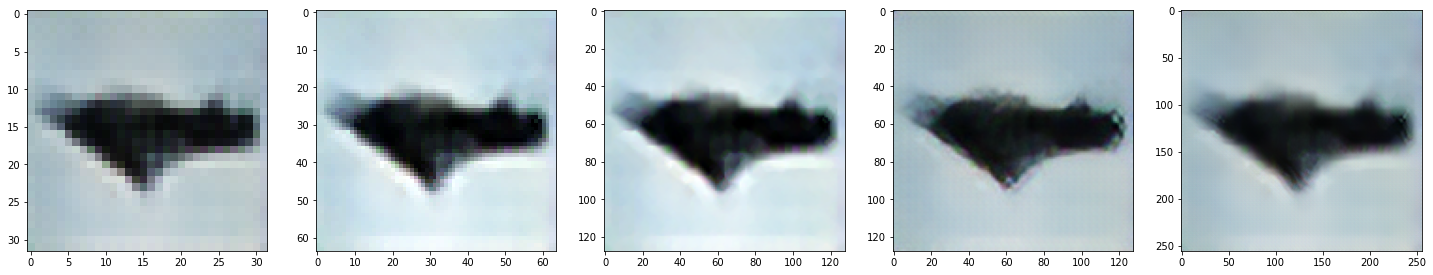

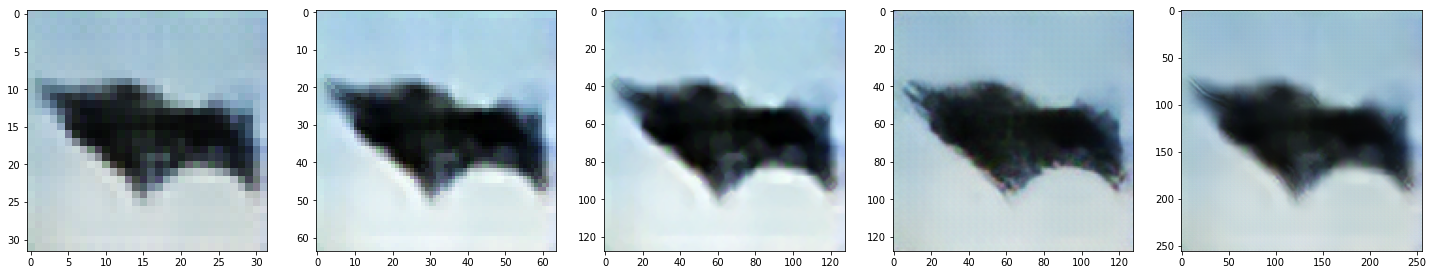

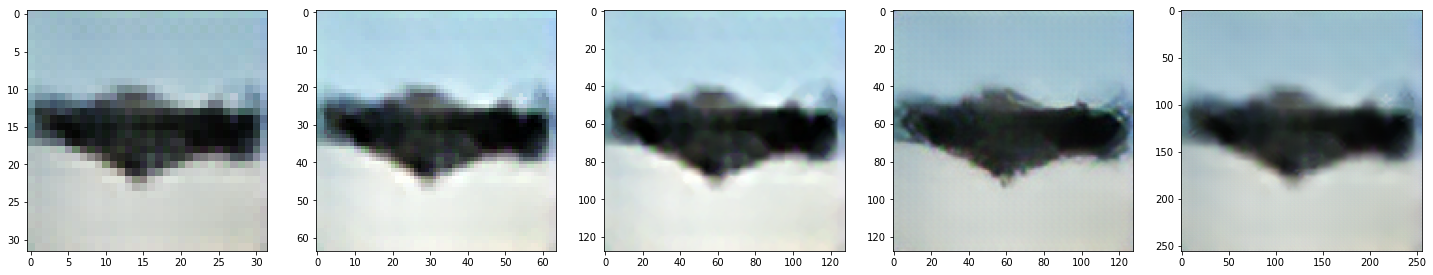

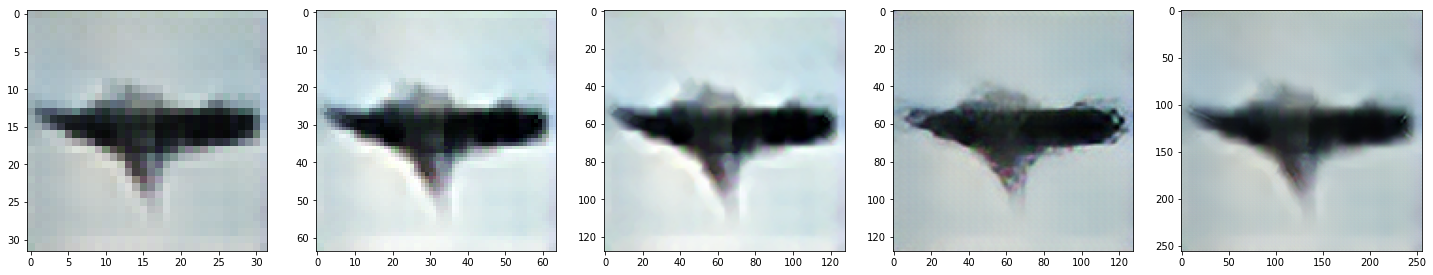

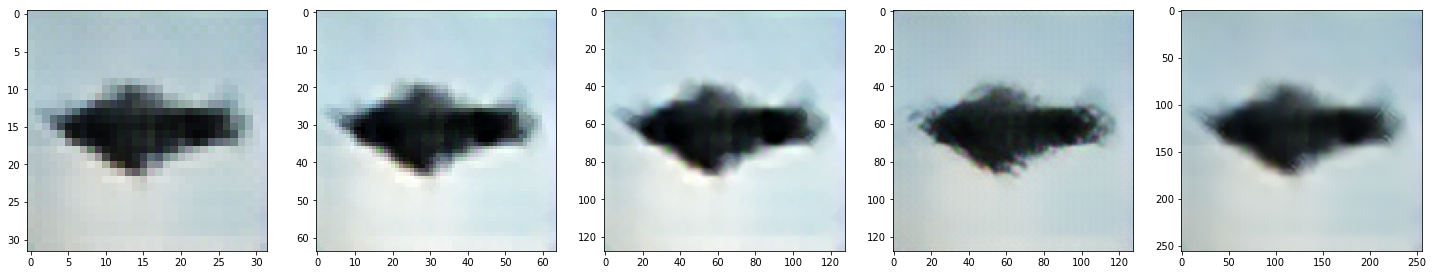

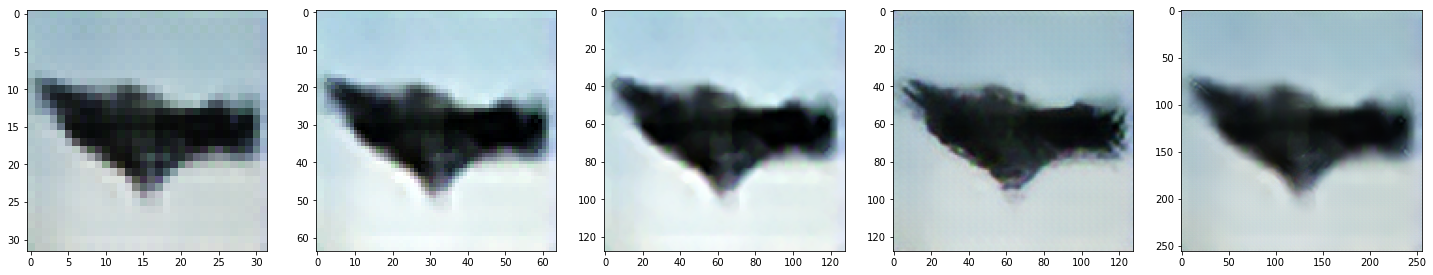

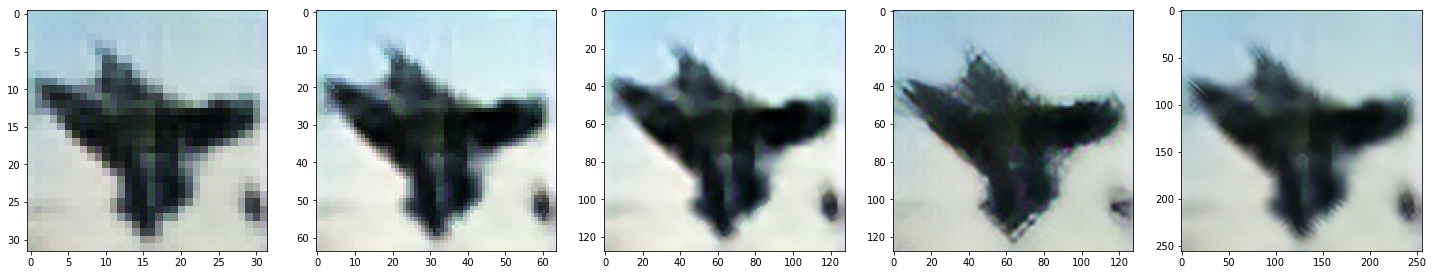

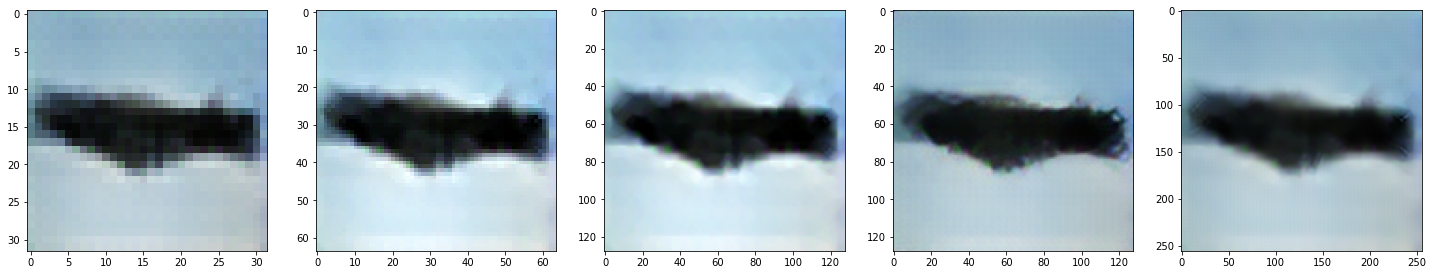

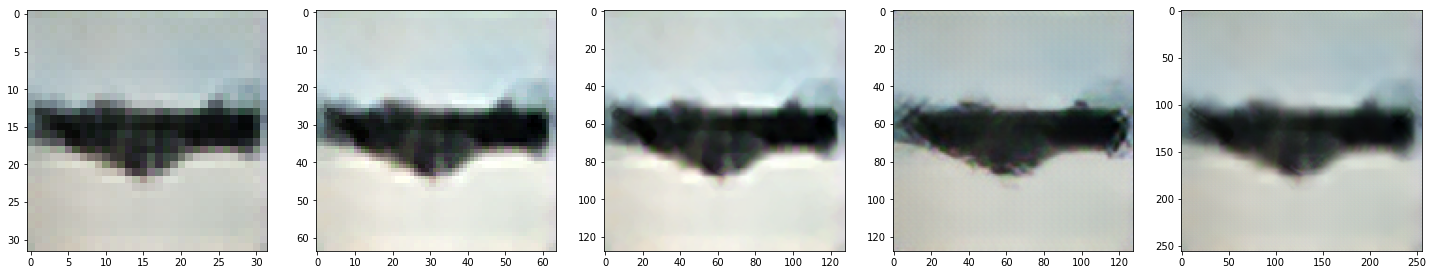

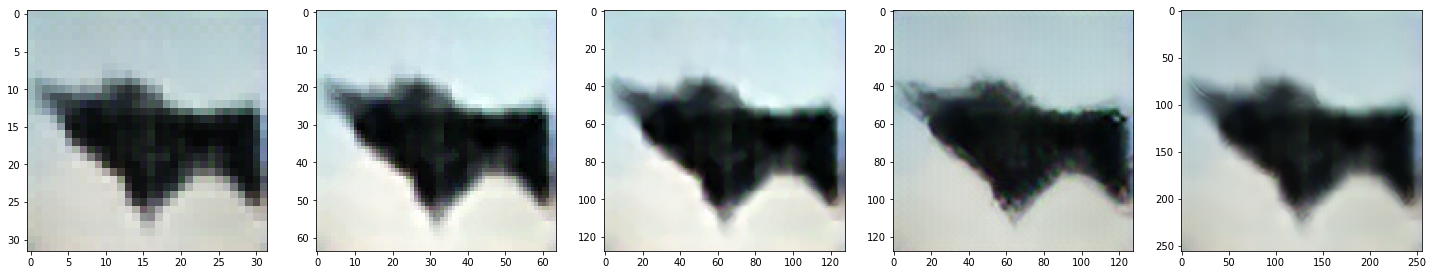

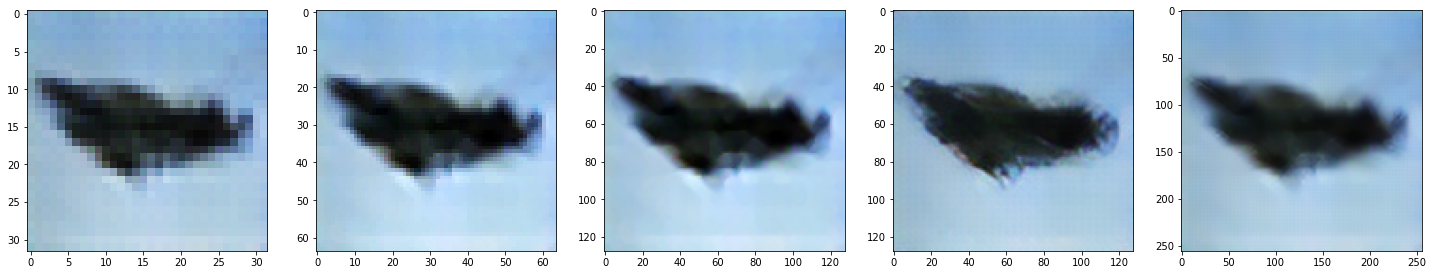

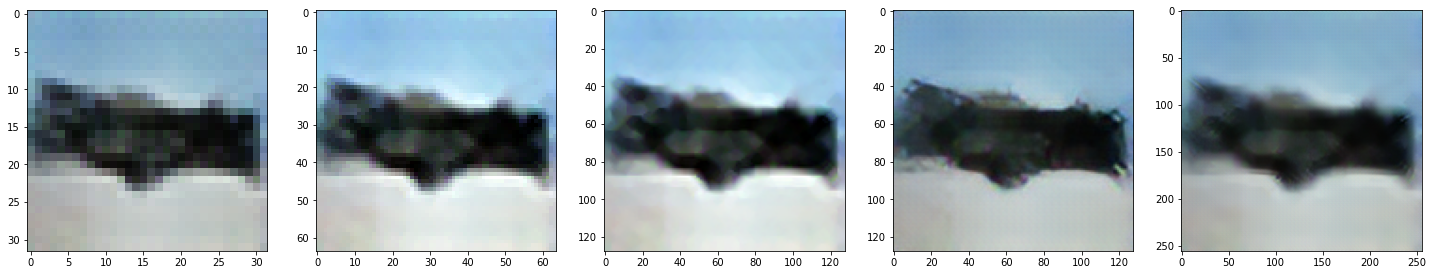

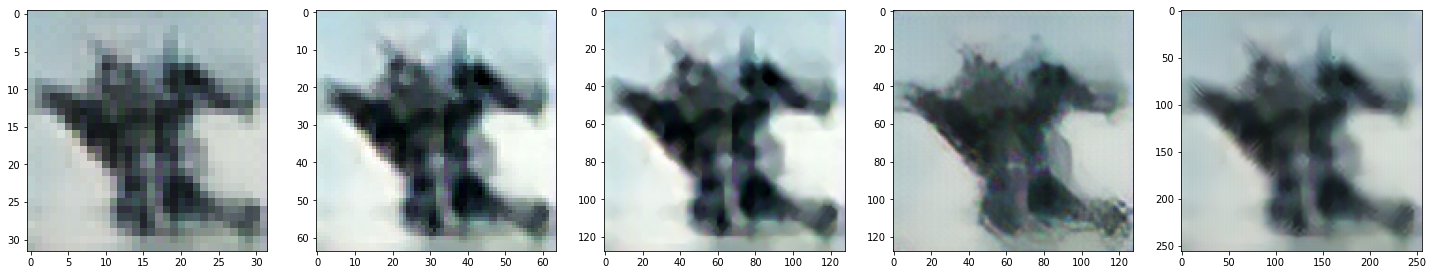

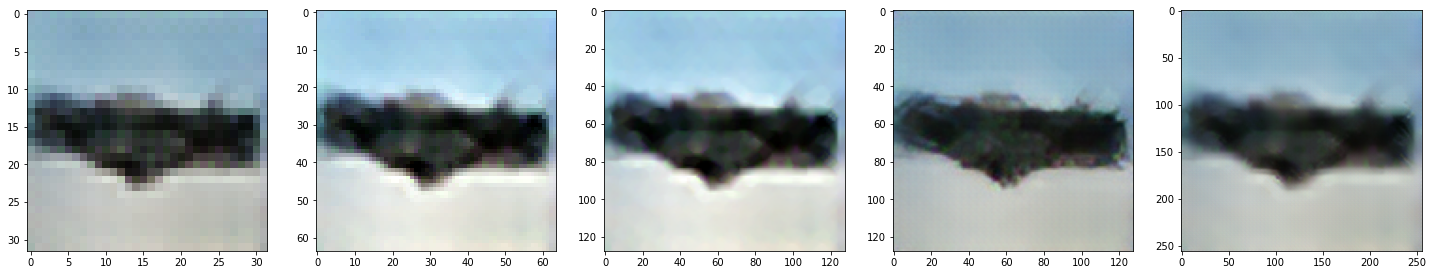

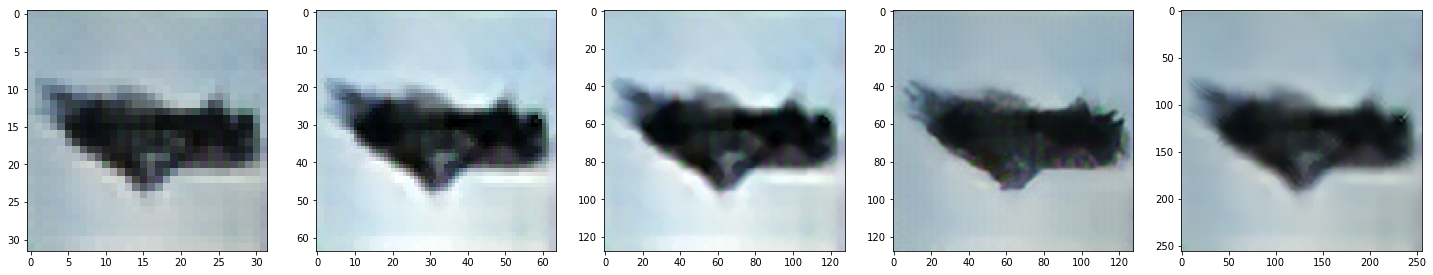

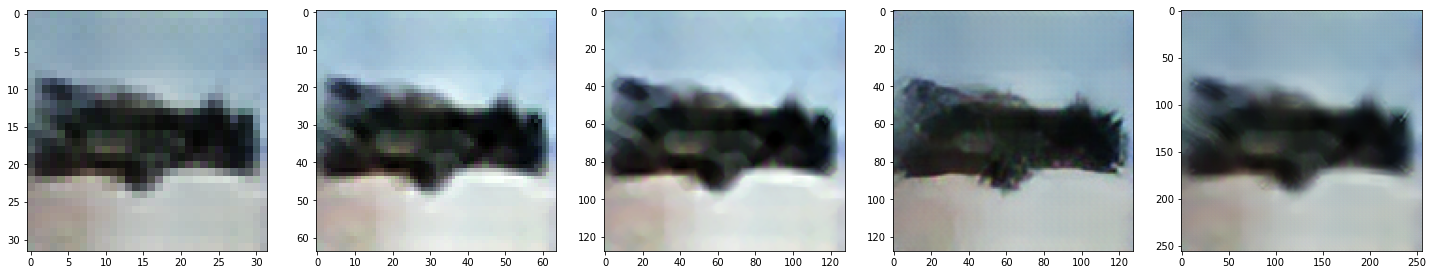

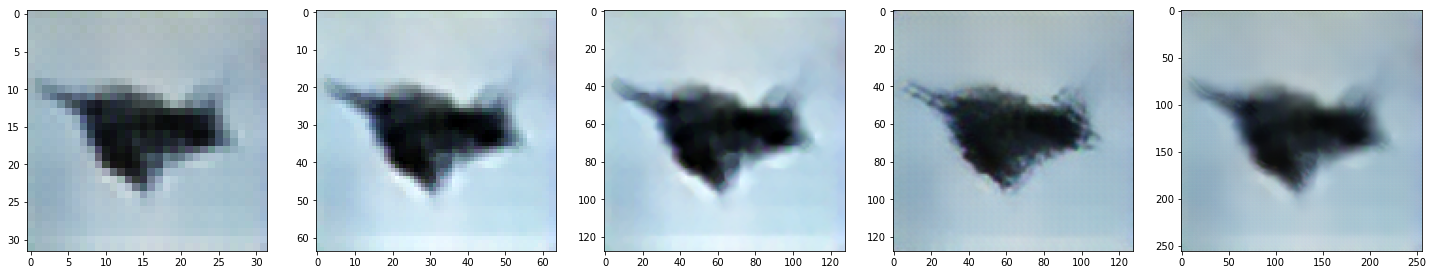

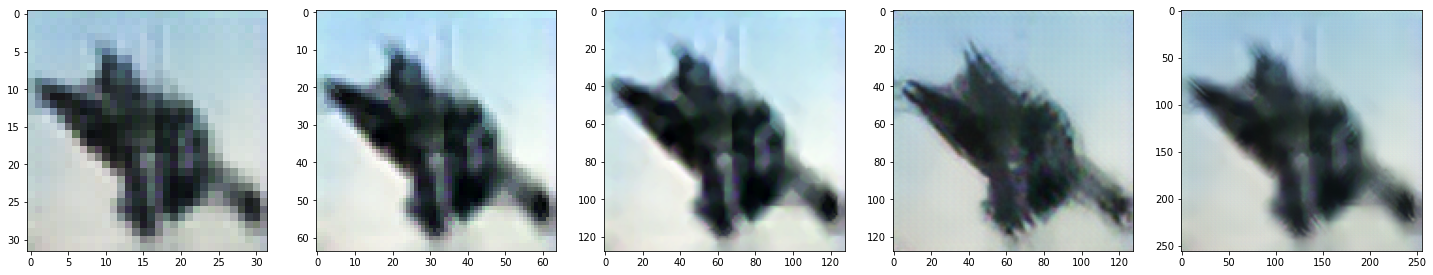

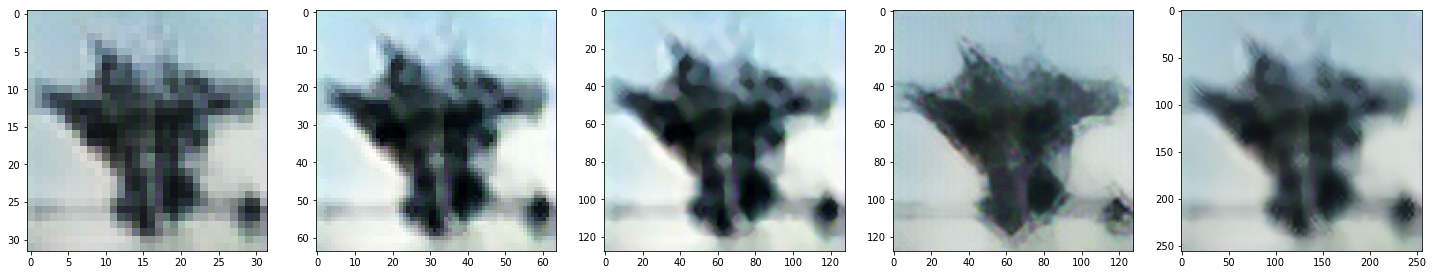

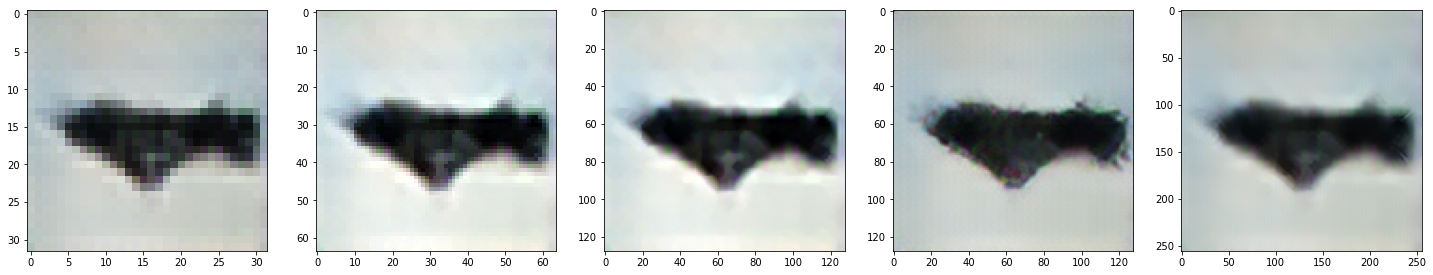

In [18]:
# Function to plot the best images generated from the model and their resized versions

def plot_images_post(model, num_generated_images):
    # plot random generated images for visual evaluation of generation quality
    
    # Generate a large number of images, to choose the best from
    num_images = 10000
    generated_images = model.generate(num_images, training=False)

    # Extract the indices of the n best generated images based on the output from the discriminator
    scores = model.discriminator(generated_images)
    v, ind = tf.math.top_k(scores[:, 0], k=num_generated_images, sorted=True)
    print(v)
    print(ind)

    # Iterate over the best images, apply the resizing and improvement functions and plot them all
    for i in range(len(ind)):

        # Extract the best images based on the indices
        ii = ind[i]
        image_tensor = generated_images[ii]

        # First resizing and sharpening of the image (output size = 64*64*3)
        sharp = postprocess(image_tensor)

        # Second resizing and sharpening of the image (output size = 128*128*3)
        sharp_array = tf.keras.preprocessing.image.img_to_array(sharp)
        sharp1 = postprocess(sharp_array)

        # Improvement of the resolution and resizing using the ESRGAN model (output size = 128*128*3)
        res_image = resize_res(image_tensor)

        # Second improvement of the resolution and resizing using the ESRGAN model (output size = 256*256*3)
        resized_image_2 = tf.image.resize(image_tensor, [64, 64], method=tf.image.ResizeMethod.BICUBIC)
        res_image_256 = resize_res(resized_image_2)

        # Plotting of all images
        imgs = [image_tensor,sharp,sharp1,res_image,res_image_256]
        display_images(imgs)
        
                
        # Saving the images
        # Convert the tensor to a PIL Image
        pil_img = tf.keras.preprocessing.image.array_to_img(image_tensor)
        pil_img_res = tf.keras.preprocessing.image.array_to_img(res_image)
        pil_img_res_256 = tf.keras.preprocessing.image.array_to_img(res_image_256)


        # Save the image to a file
        pil_img.save("best_generated_images_cifar_plane_"+str(60+i)+".png")
        sharp.save("post_images_cifar_plane_"+str(60+i)+".png")
        sharp1.save("dpost_images_cifar_plane_"+str(60+i)+".png")
        pil_img_res.save("res_images_cifar_plane_"+str(60+i)+".png")        
        pil_img_res_256.save("dres_images_cifar_plane_"+str(60+i)+".png")


num_generated_images = 20        
plot_images_post(model,num_generated_images)        

tf.Tensor(
[0.9806205  0.97682905 0.9584508  0.94811577 0.9460915  0.9451149
 0.9434115  0.94108534 0.938969   0.9370019  0.9362754  0.9353098
 0.9342777  0.93415946 0.93158805 0.9307752  0.9301058  0.92908216
 0.92846406 0.92629695], shape=(20,), dtype=float32)
tf.Tensor(
[4116 3616 3215 4517 2697 3204 3103 4395 1192 4565 2000 3183 1707 2916
 1821 4879 1260   82 2740 1764], shape=(20,), dtype=int32)


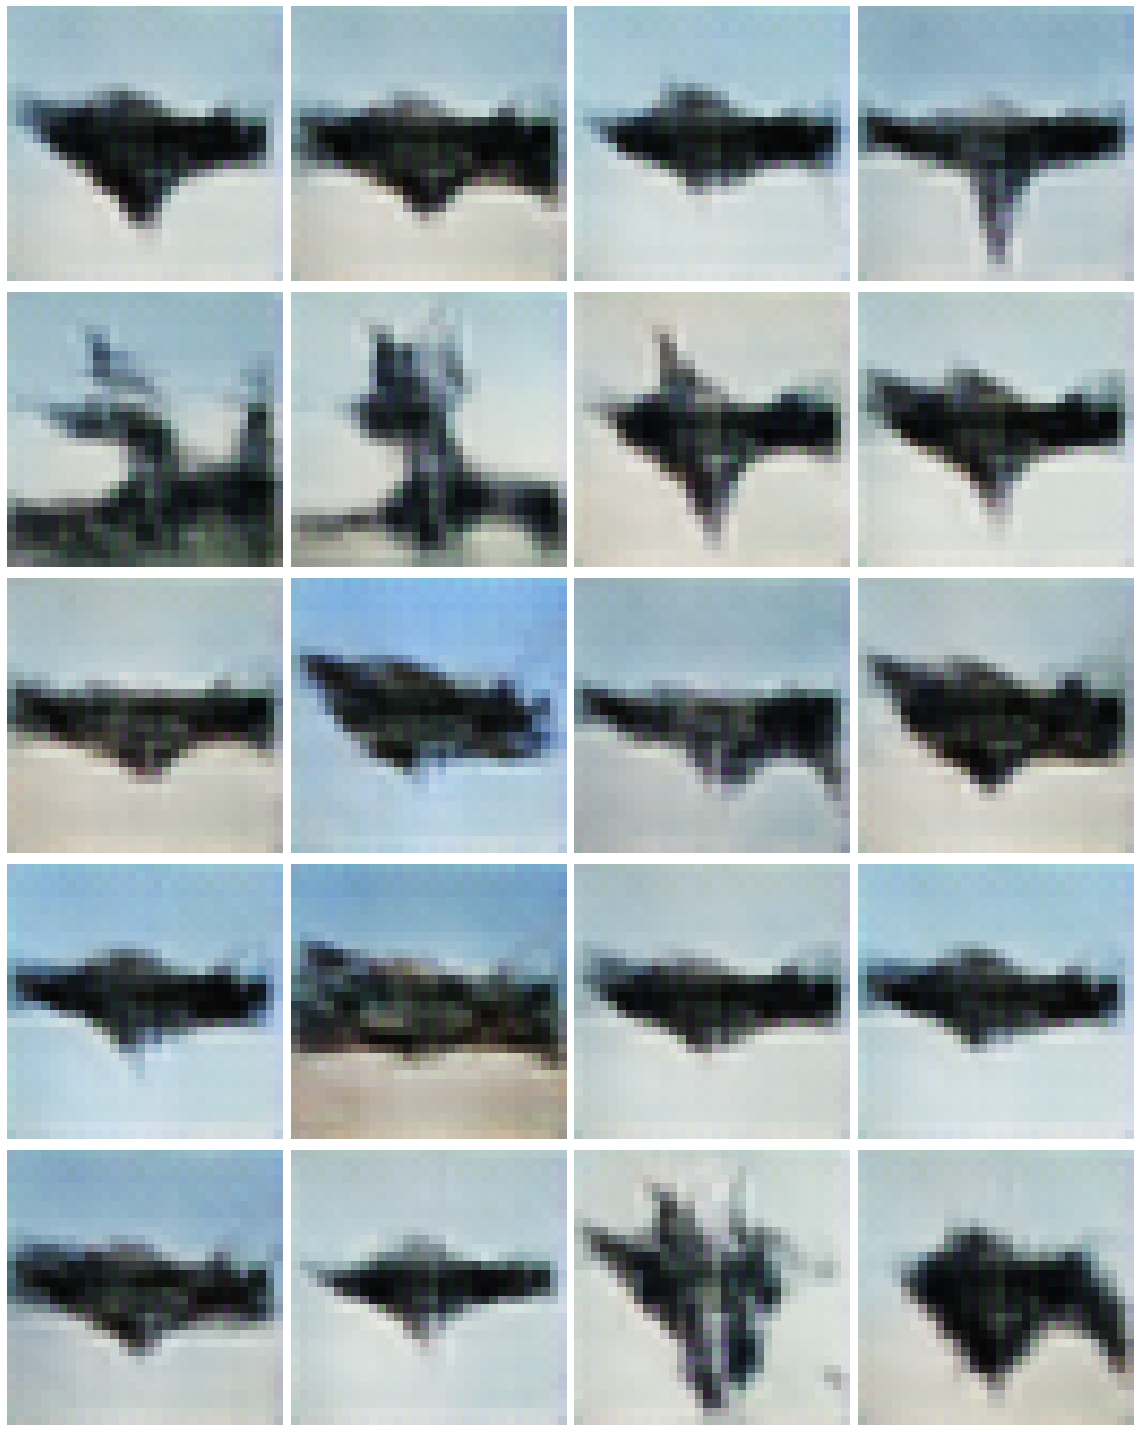

In [ ]:
def plot_images_best(model, num_rows=5, num_cols=4):
    # plot random generated images for visual evaluation of generation quality
    
    # Generate a large number of images, to choose the best from
    num_images = 5000
    generated_images = model.generate(num_images, training=False)

    # Extract the indices of the n best generated images based on the output from the discriminator
    scores = model.discriminator(generated_images)
    num_gen = num_rows * num_cols
    v, ind = tf.math.top_k(scores[:, 0], k=num_gen, sorted=False)
    print(v)
    print(ind)
    
    # Iterate over the best images and plot them all
    plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
    for row in range(num_rows):
        for col in range(num_cols):
            index = row * num_cols + col
            ii = ind[index]
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(generated_images[ii])
            
            # Convert the tensor to a PIL Image
            pil_img = tf.keras.preprocessing.image.array_to_img(generated_images[ii])

            # Save the image to a file
            pil_img.save("b_generated_images_cifar_plane_"+str(index)+".png")
            
            plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()       
        
plot_images_best(model)        

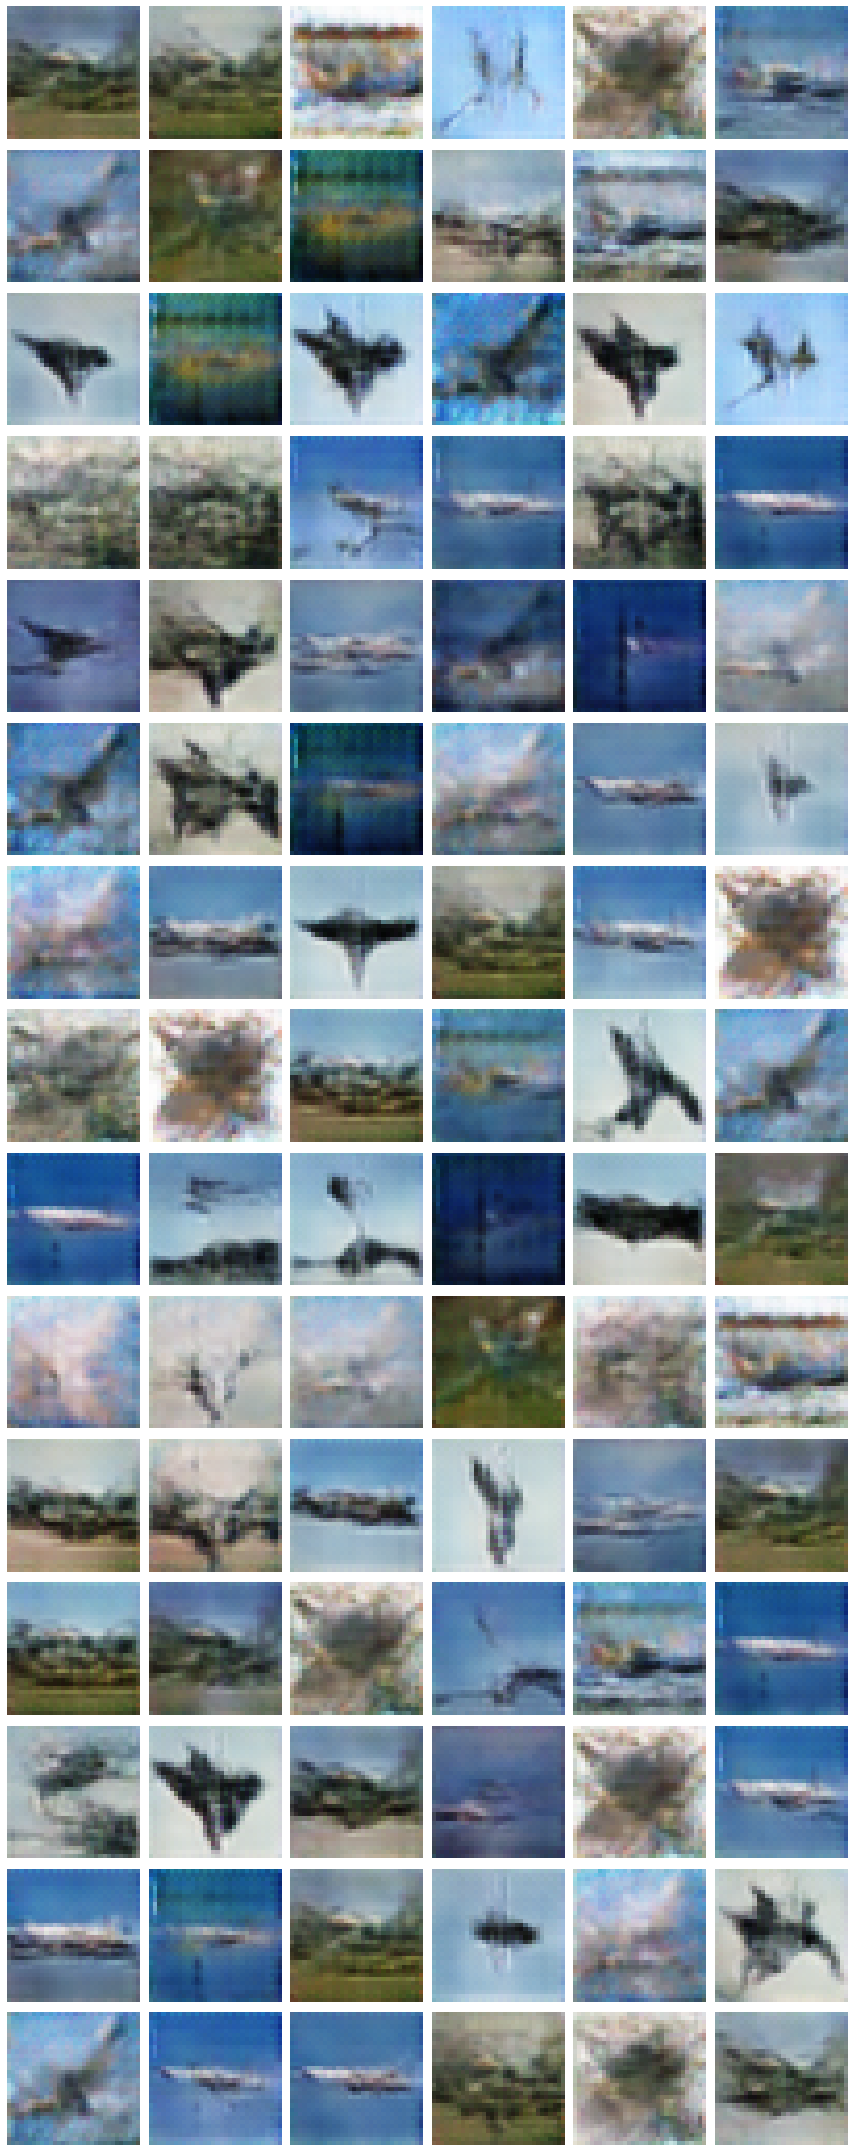

In [15]:

def plot_images_f(model, epoch=None, logs=None, num_rows=15, num_cols=6, interval=5):
    # plot random generated images for visual evaluation of generation quality
    
    num_images = num_rows * num_cols
    generated_images = model.generate(num_images, training=False)

    plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
    for row in range(num_rows):
        for col in range(num_cols):
            index = row * num_cols + col
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(generated_images[index])

            # Convert the tensor to a PIL Image
            pil_img = tf.keras.preprocessing.image.array_to_img(generated_images[index])

            # Save the image to a file
            pil_img.save("generated_images_cifar_plane_"+str(index)+".png")
            

            plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()
        
        
plot_images_f(model)        